In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import os

In [2]:
from datavyz import gen as ge

In [3]:
# fraction to be multiplied to neurpil for substraction from contaminated fluorescence
fraction = 0.7
# window length for calculating delta F over F
window_length = 800
# threshold to be applied 
percentile_threshold = 20

wdir = '/home/yann/Downloads/Clustering/'

folder_num = 1
folder  = [d for d in os.listdir(wdir) if os.path.isdir(d)][folder_num]


In [4]:
# Function to calculate delta F over F
def meandelFoverF(Fluo,window_length,percentile_threshold):                
    cells, npoints = Fluo.shape
    lpad = int(window_length) 
    npoints1 = npoints+lpad
    F_basline = np.zeros((cells, npoints))     
    for k in range(cells):
        for j in range(npoints-int(window_length)):
            array1 = Fluo[k,j:(int(window_length)+j)]
            value1 = npercent_below_avg(array1,percentile_threshold,window_length)
            F_basline[k,(j+int(window_length*0.5)-1)] = value1
            F_basline[k,:int(window_length*0.5)] = F_basline[k,int(window_length*0.5)-1]
            F_basline[k,(npoints-int(window_length*0.5)-1):npoints] = F_basline[k,(npoints-int(window_length*0.5)-2)]

    deltaFoverF = np.divide((Fluo-F_basline),F_basline)
    return deltaFoverF

In [5]:
# Computing average of values below a defined percentile
def npercent_below_avg(array,percentile_threshold,window_length):  
    value = np.percentile(array,percentile_threshold,interpolation='linear')
    index = array<=value
    value = array[index].mean()
    return value

In [6]:

# Finding fluorescence files in a given folder and laoding them
# data = np.zeros((1,9073)) # don't add artificial zeros in the data (use numpy.empty if you really want to initialize it, but here mayeb unnecessary)

for root1, dirs1, files1 in os.walk(os.path.join(wdir, folder)):
    for f in files1:
        if f=='F.npy':
            Fluo =  np.load(os.path.join(root1,'F.npy'), allow_pickle=True)
            stat = np.load(os.path.join(root1,'stat.npy'), allow_pickle=True)
            iscell = np.load(os.path.join(root1,'iscell.npy'), allow_pickle=True)
            neuropil = np.load(os.path.join(root1,'Fneu.npy'), allow_pickle=True)
            Fluo = Fluo[iscell[:,0].astype(bool)]
            neuropil = neuropil[iscell[:,0].astype(bool)]
            cells = len(Fluo)
            val = np.mean(Fluo,axis=1)<(1.5*np.mean(neuropil, axis=1))
            Fluo = Fluo[val]
            neuropil = neuropil[val]
            Fluo = Fluo-(fraction*neuropil)
            fluorescence = meandelFoverF(Fluo,window_length,percentile_threshold)

data = fluorescence
# a nice dictionary with keys 'cell1', 'cell2', ...
Data, mean_Data, std_Data, norm_Data = {}, {}, {}, {}

for i in range(data.shape[0]):
    Data['cell%i' % (i+1)] = data[i]
    mean_Data['cell%i' % (i+1)] = data[i].mean()
    std_Data['cell%i' % (i+1)] = data[i].std()
    norm_Data['cell%i' % (i+1)] = (data[i]-data[i].mean())/data[i].std()
    

In [7]:

def activity_plot(Data,
                  Data_original=None,
                  tzoom=[0, np.inf], dt=1, 
                  ax=None, bar_fraction=0.7, Tbar=10, lw=0.5):
    
    if ax is None:
        _, ax = ge.figure(axes_extents=(4,4))

    keys = [key for key in Data]
    t = np.arange(len(Data[keys[0]]))*dt
    t_cond = (t>=tzoom[0]) & (t>=tzoom[0])

    for i, key in enumerate(Data):
        if Data_original is not None:
            norm_factor = 1./(np.max(Data_original[key][t_cond])-np.min(Data_original[key][t_cond]))
            baseline = np.min(Data_original[key][t_cond])
            norm_Data_original = (Data_original[key][t_cond]-baseline)*norm_factor
            ax.plot(t[t_cond], i+norm_Data_original, ge.colors[i%10], lw=0.2, alpha=.3)
        else:
            norm_factor = 1./(np.max(Data[key][t_cond])-np.min(Data[key][t_cond]))
            baseline = np.min(Data[key][t_cond]) 
           
        norm_Data = norm_factor*(Data[key][t_cond]-baseline)

        ax.plot(t[t_cond], i+norm_Data, ge.colors[i%10], lw=lw)
        ge.annotate(ax, key, (t[t_cond][-1], i+1), color=ge.colors[i%10],
                    xycoords='data', ha='right', size='small', va='top')
        
        # scale for that cell
        ax.plot([0, 0], [i, i+bar_fraction], color=ge.default_color)
        
        ge.annotate(ax, '%.1f%%' % norm_factor, (0, i), rotation=90, xycoords='data', ha='right', size='small')
        
    ax.plot([0, Tbar], [i+1, i+1], color=ge.default_color)
    ge.annotate(ax, '%is' % Tbar, (0, i+1), xycoords='data', size='small')
    
    ax.axis('off')


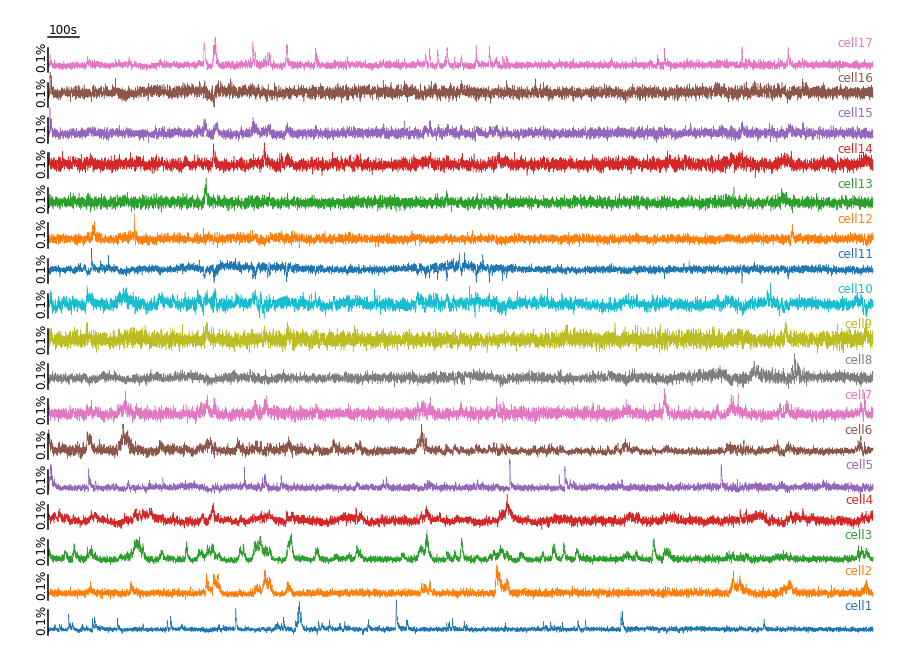

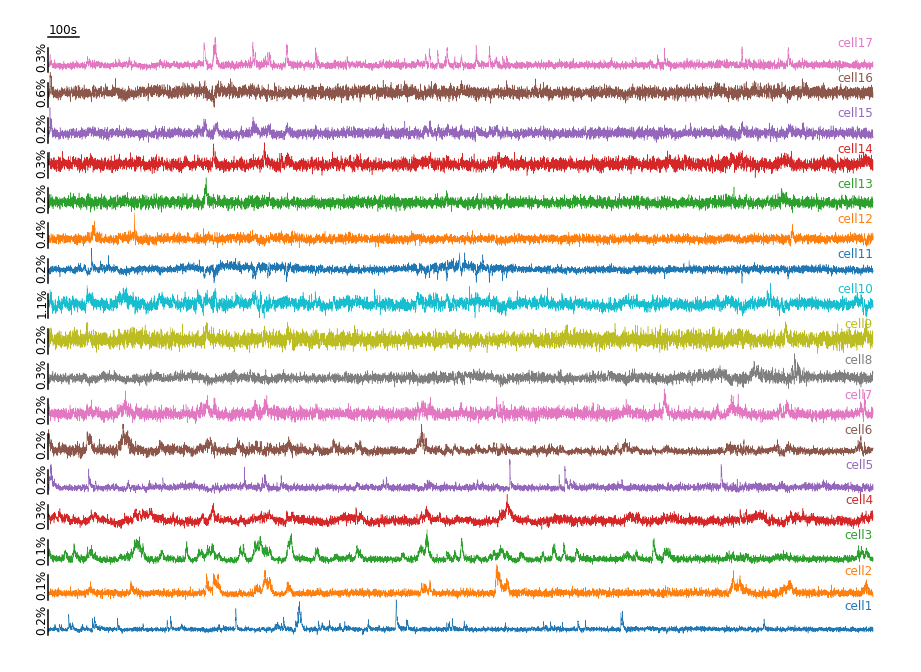

In [9]:
activity_plot(Data, dt=0.3, Tbar=100)

In [10]:
# Estimations of PCs
def pc_calculation(fluoro_trace, method = 'StandardScaler', n_comp = 2):
    
    pca = PCA(n_components=n_comp)
    
    if method =='StandardScaler':
        F_normal = StandardScaler().fit_transform(fluoro_trace.T)
        pc = pca.fit_transform(F_normal.T)
        
    if method == 'MinMaxScaler':
        scaler = MinMaxScaler(feature_range=[0,1])
        F_rescaled = scaler.fit_transform(fluoro_trace.T) 
        pc = pca.fit_transform(F_rescaled.T)
    
    
    return pc

In [25]:
from sklearn.decomposition import PCA as sklPCA

def PCA(data,
        n_components=2, desired_var_explained=None):

    if desired_var_explained is not None:
        pca = sklPCA(n_components=desired_var_explained)
    else:
        pca = sklPCA(n_components=n_components)

    X = np.array([data[key] for key in data]).T # insuring shape (n_samples, n_features)
    pca.fit(X) 

    return pca


# run PCA
pca = PCA(Data, n_components = len(Data)) # desired_var_explained=0.9)       


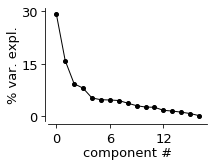

In [26]:
# let's plot the variance explained by the components
ge.plot(100.*pca.explained_variance_ratio_,
         m='o', ms=4, xlabel='component #', ylabel='% var. expl.');

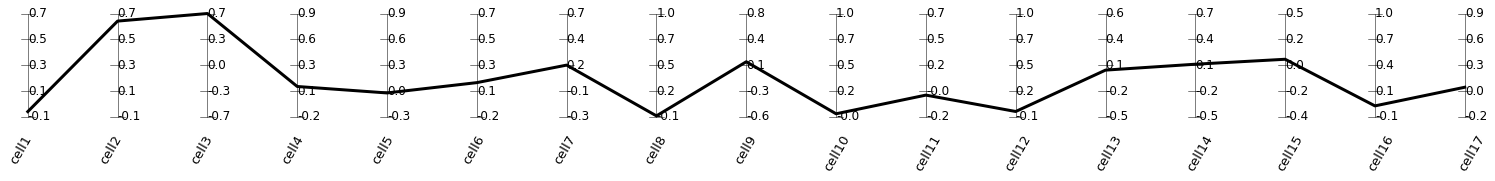

In [28]:
# visualizing the component
# -> visualizing the comodulation pattern corresponding to a component

i0, i1 = 0, 1
ge.parallel_plot(pca.components_[i0:i1],
                 SET_OF_LIMS=[[pca.components_[:,i].min(), pca.components_[:,i].max()] for i in range(len(Data))],
                 # SET_OF_LIMS=[[-1, 1] for i in range(len(Data))],
                 SET_OF_LABELS=list(Data.keys()), lw=3,
                 tick_number = 5, tick_size=0.01, 
                 fig_args=dict(figsize=(2,1), bottom=.5, left=.5, right=2.),
                 label_annotation_args=dict(va='top', ha='center',rotation=60.));

In [18]:
# see the output of the first component
pca = PCA(norm_Data, n_components = 1)
X = np.array([norm_Data[key] for key in Data]).T # insuring shape (n_samples, n_features)
X_new = pca.fit_transform(X)
X1 = pca.inverse_transform(X_new)
pc1_Data = {}
for i, key in enumerate(Data):
    pc1_Data[key] = X1[:,i]*std_Data[key]+mean_Data[key]


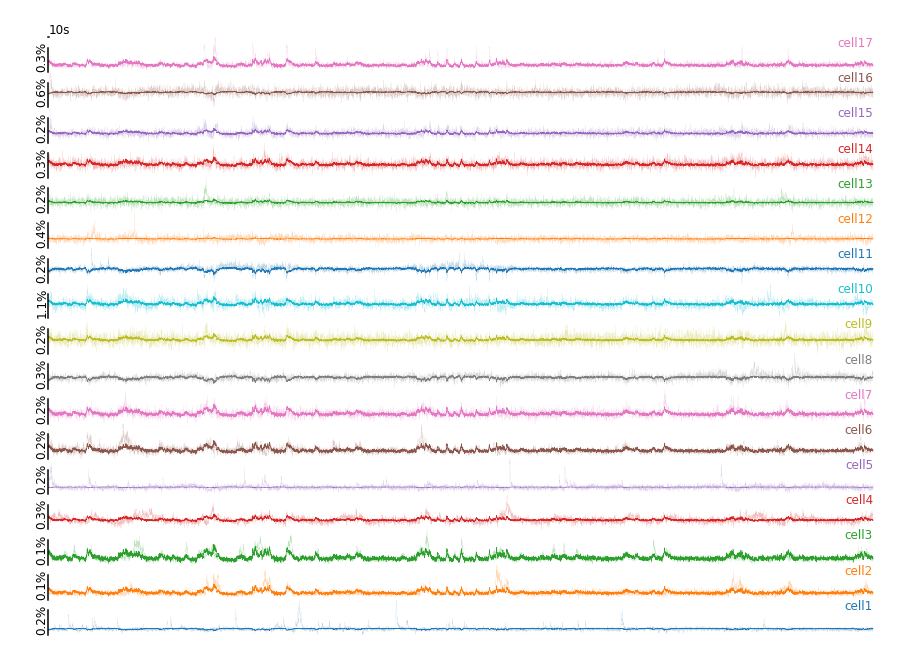

In [19]:
activity_plot(pc1_Data, Data_original=Data)

In [20]:
# see the output of the second component
pca = PCA(norm_Data, n_components = 2)
X = np.array([norm_Data[key] for key in Data]).T # insuring shape (n_samples, n_features)
X_new = pca.fit_transform(X)
X2 = pca.inverse_transform(X_new)
pc2_Data = {}
for i, key in enumerate(Data):
    pc2_Data[key] = (X2[:,i]-X1[:,i])*std_Data[key]+mean_Data[key]


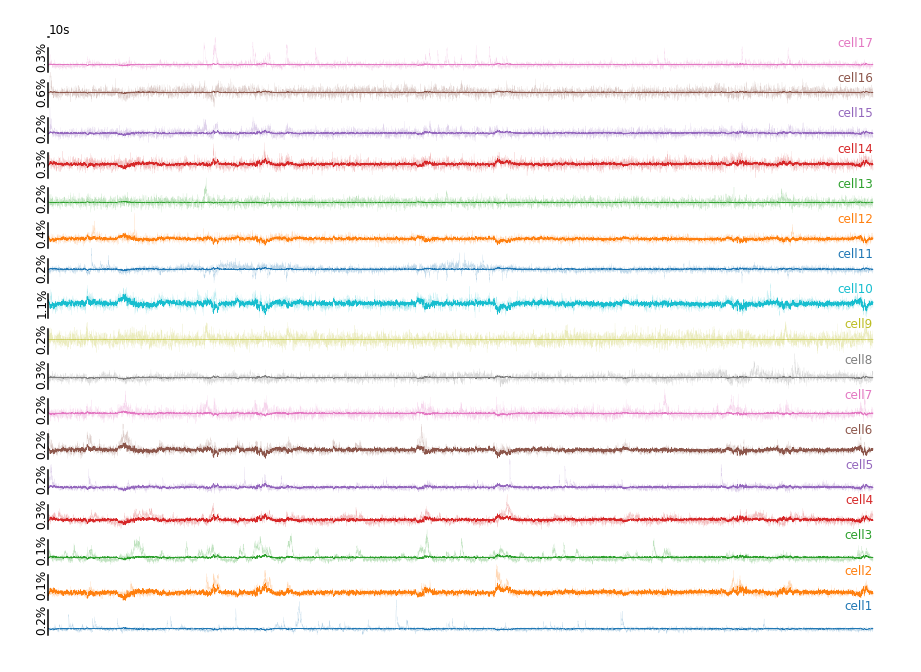

In [21]:
activity_plot(pc2_Data, Data_original=Data)

In [65]:
# calculating delta Fover F
df  = meandelFoverF(Fluo,window_length,percentile_threshold)

# Calculating two Principal components
pc = pc_calculation(df)
pc1_normfactor = np.max(np.abs(pc[:,0]))
pc2_normfactor = np.max(np.abs(pc[:,1]))

pc[:,0] = pc[:,0]/pc1_normfactor
pc[:,1] = pc[:,1]/pc2_normfactor

In [66]:
# Calculating labels for 3 clusters
kmeans = KMeans(n_clusters = 3, random_state=0).fit(pc)

# Extracting values belonging to one of the three classes
class1 = kmeans.labels_==0
class2 = kmeans.labels_==1
class3 = kmeans.labels_==2

class1 = pc[class1]
class2 = pc[class2]
class3 = pc[class3]

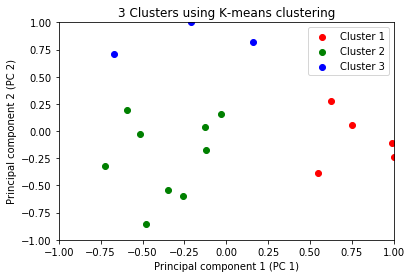

In [67]:
# Plotting of the clusters

fig1 = plt.figure(1)

plt.title("3 Clusters using K-means clustering")
plt.xlabel("Principal component 1 (PC 1)")
plt.ylabel("Principal component 2 (PC 2)")

plt.ylim(-1,1)
plt.xlim(-1,1)

plt.scatter(class1[:,0],class1[:,1], c = 'r', label = 'Cluster 1')
plt.scatter(class2[:,0],class2[:,1], c = 'g', label= 'Cluster 2')
plt.scatter(class3[:,0],class3[:,1], c = 'b', label = 'Cluster 3')

plt.legend(loc = 'upper right')
